In [1]:
# Import libraries

import matplotlib.pyplot as plt
import pandas as pd
import warnings
from econml.sklearn_extensions.linear_model import WeightedLassoCV
import sklearn.model_selection as sms
import sklearn.linear_model as slm
import sklearn.preprocessing as skp
import sklearn.metrics as sme
import sklearn.feature_selection as skf
import sklearn.ensemble as ske
import sklearn.utils as sku
import sklearn.decomposition as skd
import sklearn.neural_network as skn
from celer import GroupLassoCV
from sklearnex import patch_sklearn, config_context
from sklearn.cluster import DBSCAN
import numpy as np
import scipy.stats as stats
from IPython.display import HTML
import util
from scipy.spatial import cKDTree
import nibabel as nib
import os
import pickle
from torch import nn
from rvae import VAE
from rvae import train_model
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
HTML('''
<style>
.jupyter-matplotlib {
    background-color: #000;
}

.widget-label, .jupyter-matplotlib-header{
    color: #fff;
}

.jupyter-button {
    background-color: #333;
    color: #fff;
}
</style>
''')

In [3]:
# Maybe y should also be scaled? 
# Perhaps a transform would be more effective, or scaling implemented with consistent cross-validation
# Different scaling methods? 
#     This seems most important for noise-sensitive models like LARS. All other use StandardScaler()
# Transformers?
# Model-specific scaling methods?
#     Yes, see above
# Common cross-validation function ✓
#     Use built-in functions wherever possible and `utils.gridsearch_pickparams()` elsewhere
# Quantile loss
# RANSAC
# Data augmentation? (Mixup)
# Data generation? (SMOGN)
# Combine CHH dataset ✓
# Implement CV and test ✓
# Print selected features ✓
# Make magnitude templates
# Sample weights ✓
# Look at segmentations by error ✓ (Appears to have most difference in red nucleus, which includes surrounding (white?) matter for underperforming cases)
# Extract features from current (1:6) eroded ROIs
# Extract features from all ROIs
# Plot segmentation variance against error for each case across all ROIs ✓
# Why does excluding the subthalamic nucleus increase the correlation (r=0.5 -> r=0.6)?
# Best performance with all ROIs: cvn=6, k=1800
# Best performance with ROIs 0:4, excluding STN: cvn=6, k=1800
# Should the pre-operative UPDRS be appended once or to each ROI? ✓
# Plot histogram of features for successful and unsuccessful predictions

In [4]:
# Get case IDs
case_list = open('/home/ali/RadDBS-QSM/data/docs/cases_90','r')
lines = case_list.read()
lists = np.loadtxt(case_list.name,comments="#", delimiter=",",unpack=False,dtype=str)
case_id = []
for lines in lists:     
    case_id.append(lines[-9:-7])

# Load scores
file_dir = '/home/ali/RadDBS-QSM/data/docs/QSM anonymus- 6.22.2023-1528.csv'
motor_df = util.filter_scores(file_dir,'pre-dbs updrs','stim','CORNELL ID')
# Find cases with all required scores
subs,pre_imp,post_imp,pre_updrs_off = util.get_full_cases(motor_df,
                                                          'CORNELL ID',
                                                          'OFF (pre-dbs updrs)',
                                                          'ON (pre-dbs updrs)',
                                                          'OFF meds ON stim 6mo')
# Load extracted features
npy_dir = '/home/ali/RadDBS-QSM/data/npy/'
phi_dir = '/home/ali/RadDBS-QSM/data/phi/phi/'
roi_path = '/data/Ali/atlas/mcgill_pd_atlas/PD25-subcortical-labels.csv'
n_rois = 6
all_rois = False
Phi_all, X_all, R_all, K_all, ID_all = util.load_featstruct(phi_dir,npy_dir+'X/',npy_dir+'R/',npy_dir+'K/',n_rois,1595,all_rois)

ids = np.asarray(ID_all).astype(int)
# Find overlap between scored subjects and feature extraction cases
c_cases = np.intersect1d(np.asarray(case_id).astype(int),np.asarray(subs).astype(int))
# Complete case indices with respect to feature matrix
c_cases_idx = np.in1d(ids,c_cases)
X_all_c = X_all[c_cases_idx,0:4,:]
K_all_c = K_all[c_cases_idx,0:4,:]
R_all_c = R_all[c_cases_idx,0:4,:]
print(R_all_c)
# Re-index the scored subjects with respect to complete cases
s_cases_idx = np.in1d(subs,ids[c_cases_idx])
subsc = subs[s_cases_idx]
pre_imp = pre_imp[s_cases_idx]
post_imp = post_imp[s_cases_idx]
pre_updrs_off = pre_updrs_off[s_cases_idx]
per_change = post_imp
# Reshape keys and ROIs
if all_rois == True:
    K_all_cu = np.empty((K_all_c.shape[0],K_all_c.shape[1],K_all_c.shape[2]+1),dtype=object)
    K_all_cu[:,:,:-1] = K_all_c
    K_all_cu[:,:,-1] = 'pre_updrs'
    K = K_all_cu.reshape((K_all_cu.shape[0],K_all_cu.shape[1]*K_all_cu.shape[2]))[0]
    R = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))
else:
    K = K_all_c.reshape((K_all_c.shape[0],K_all_c.shape[1]*K_all_c.shape[2]))[0]
    K = np.append(K,['pre_updrs'],0)
    R = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))


Allocated arrays
Created feature matrix
Created ROI matrix
Created feature label matrix
[[['Left red nucleus' 'Left red nucleus' 'Left red nucleus' ...
   'Left red nucleus' 'Left red nucleus' 'Left red nucleus']
  ['Right red nucleus' 'Right red nucleus' 'Right red nucleus' ...
   'Right red nucleus' 'Right red nucleus' 'Right red nucleus']
  ['Left substantia nigra' 'Left substantia nigra'
   'Left substantia nigra' ... 'Left substantia nigra'
   'Left substantia nigra' 'Left substantia nigra']
  ['Right Substantia nigra' 'Right Substantia nigra'
   'Right Substantia nigra' ... 'Right Substantia nigra'
   'Right Substantia nigra' 'Right Substantia nigra']]

 [['Left red nucleus' 'Left red nucleus' 'Left red nucleus' ...
   'Left red nucleus' 'Left red nucleus' 'Left red nucleus']
  ['Right red nucleus' 'Right red nucleus' 'Right red nucleus' ...
   'Right red nucleus' 'Right red nucleus' 'Right red nucleus']
  ['Left substantia nigra' 'Left substantia nigra'
   'Left substantia nigra

In [5]:
# # Augment with CHH data
# X0_gt = np.load('/home/ali/RadDBS-QSM/data/npy/old/X0_gt_chh_rois.npy')
# df = pd.read_csv('/home/ali/RadDBS-QSM/data/xlxs/updrs_iii_chh.csv')
# # Patient IDs
# subject_id = np.asarray(df[df.columns[0]])[1:]
# # Data
# s_directory = open('/home/ali/RadDBS-QSM/data/roi/roi_list','r').read().splitlines()
# # Load
# with open('/home/ali/RadDBS-QSM/data/pickles/segs_chh', "rb") as fp:  
#     segs = pickle.load(fp)
#     n_cases = len(segs)
# with open('/home/ali/RadDBS-QSM/data/pickles/qsms_chh', "rb") as fp:  
#     qsms = pickle.load(fp)
# with open('/home/ali/RadDBS-QSM/data/phi/chh/Phi_mcl_gt_roi_chh', "rb") as fp:  
#         Phi_gt = pickle.load(fp)
# L = int(len(X0_gt)/n_cases)
# n_features = int(L/n_rois)
# # Only extract ROI if it is present in all cases
# seg_labels_all = segs[0]
# case_number = np.zeros_like(np.asarray(s_directory))
# for i in range(n_cases):
#     case_number[i] = float(s_directory[i][-2:])
# subject_id_corr = subject_id[np.in1d(subject_id,case_number)]
# for i in range(n_cases):
#     #try:
#         print('Found ROIs',str(np.unique(segs[i])),'at segmentation directory file',s_directory[i],'for case',str(subject_id_corr[i]))
#     #except:
#         print('Case',subject_id[i],'quarantined')
# pre_updrs_iii_off =  np.asarray(df[df.columns[3]][np.hstack((False,np.in1d(subject_id,subject_id_corr)))])                                
# pre_updrs_iii_on =  np.asarray(df[df.columns[4]][np.hstack((False,np.in1d(subject_id,subject_id_corr)))])
# post_updrs_iii_off =  np.asarray(df[df.columns[6]][np.hstack((False,np.in1d(subject_id,subject_id_corr)))])

# per_change = np.hstack((per_change,(np.asarray(pre_updrs_iii_off).astype(float)-np.asarray(post_updrs_iii_off).astype(float))/(np.asarray(pre_updrs_iii_off).astype(float))))
# pre_updrs_off = np.hstack((pre_updrs_off, pre_updrs_iii_off))
# X0_gt = X0_gt.reshape((n_cases,n_rois,n_features))[:,0:4,:]
# X_all_c = np.vstack((X_all_c,X0_gt[:,:,:-1]))
# lct_change = (np.asarray(pre_updrs_iii_off).astype(float)-(np.asarray(pre_updrs_iii_on)).astype(float))/(np.asarray(pre_updrs_iii_off).astype(float))
# pre_imp = np.hstack((pre_imp,lct_change))
# subject_id_corr=subject_id_corr+100
# subsc = np.hstack((subsc,subject_id_corr))

In [6]:
# nii_dir = '/home/ali/RadDBS-QSM/data/nii'
# qsms = []
# segs = []
# for j in np.arange(len(subsc)):
#     if subsc[j] < 10:
#         qsms.append(nii_dir+'/qsm/QSM_e10_imaginary_0'+str(int(subsc[j]))+'.nii.gz')
#         segs.append(nii_dir+'/seg/labels_2iMag0'+str(int(subsc[j]))+'.nii.gz')
#     else:
#         qsms.append(nii_dir+'/qsm/QSM_e10_imaginary_'+str(int(subsc[j]))+'.nii.gz')
#         segs.append(nii_dir+'/seg/labels_2iMag'+str(int(subsc[j]))+'.nii.gz')

# V, M, subs_err = util.roi_var(qsms,segs,[1,2,3,4,5,6])
# np.save('V.npy',V)
# np.save('U.npy',M)
# V = np.load('V.npy')
# M = np.load('U.npy')

In [7]:
scoring = 'r2'
results_bls = np.zeros_like(per_change)
results_ls = np.zeros_like(per_change)
results_gls = np.zeros_like(per_change)
gerror = np.zeros_like(per_change)
alphas = np.logspace(-4,4,100)
Ks = []
Kstg = []
w = []
wg = []

In [8]:
# chi = []
# for j in np.arange(len(qsms)):
#     data = nib.load(qsms[j]).get_fdata()
#     if int(qsms[j][-9:-7]) == int(segs[j][-9:-7]):
#         try:
#             mask = nib.load(segs[j]).get_fdata()
#             img = util.pad_to((data[:,:,~(mask==0).all((0,1))])[192:320,192:320,:],128,128,108)
#             chi.append(img)
#             print('Loading',qsms[j],'of shape',str(img.shape))
#         except:
#             print('Skipping',qsms[j])
#             subsc = np.delete(subsc,j)
#             per_change = np.delete(per_change,j)
#             X_all_c = np.delete(X_all_c,j,axis=0)
#             pre_updrs_off = np.delete(pre_updrs_off,j)

In [12]:
for j in np.arange(len(subsc)):
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_train = X_all_c[train_index,:,:]
    X_test = X_all_c[test_index,:,:]
    y_train = per_change[train_index]
    y_test = per_change[test_index]
    # chi_train = np.asarray(chi)[train_index,:,:,:]
    # chi_test = np.asarray(chi)[test_index,:,:,:]
    # Cross validation
    cvn = 6
    X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                X_train,train_index,X_test,test_index,pre_updrs_off,False)
    # X_smognl,y_smognl = util.rad_smogn(X0_ss0,y_train,np.min(y_train),np.mean(y_train),1,0,0.5,0.02)
    # X0_ss0 = np.vstack((X0_ss0,X_smognl))#[y_smognl<=0.3,:]))
    # y_train = np.hstack((y_train,y_smognl))#[y_smognl<=0.3]))
    with np.errstate(divide='ignore', invalid='ignore'):
      # Feature selection
      sel = skf.SelectKBest(skf.r_regression,k=2925)
      X0_ss = sel.fit_transform(X0_ss0,y_train)
      X_test_ss = sel.transform(X_test_ss0)
      #Ks.append(sel.transform(K.reshape(1, -1)))
      #X_smognh,y_smognh = util.rad_smogn(X0_ss,y_train,np.max(y_train),np.mean(y_train),1,0,0.75,0.01)

      autoencoder = VAE()
      Xp, lvs, ys, Xpt, lvst, yi, yh, yht = train_model(X0_ss,y_train,autoencoder,X_test_ss,subsc[j])
      scaler_lvs = skp.StandardScaler()
      print('Reconstruction error of',np.sum((X_test_ss-Xpt.cpu().detach().numpy())**2),'with prediction',str(yh[0].item()),
            'for case with',str(np.round(per_change[j],2)))
      results_gls[j] = yht[0].item()
      lvs = lvs.cpu().detach().numpy()
      lvst = lvst.cpu().detach().numpy()
      y_n = cKDTree(lvs).query(lvst, k=1)[1]
      y_0 = cKDTree(X0_ss).query(X_test_ss, k=1)[1]
    # LASSO
    lasso = slm.LassoLarsCV(max_iter=1000,cv=cvn,n_jobs=-1,normalize=False,eps=0.1)
    lars = slm.LassoLarsCV(max_iter=1000,cv=cvn,n_jobs=-1,normalize=False,eps=0.1)
    est_ls = lars.fit(lvs,y_train)
    results_ls[j] = est_ls.predict(lvst)
    est_bls = lars.fit(X0_ss,y_train)
    results_bls[j] = est_bls.predict(X_test_ss)
#     #w.append(est_ls.coef_)
    print('Latent Lasso predicts',str(np.round(results_ls[j],2)),
          'for case with',str(np.round(per_change[j],2)),
          'with regularization',str(np.round(est_ls.alpha_,4)),
          'and latent neighbor ',str(y_train[y_n]))
    print('Lasso predicts',str(np.round(results_bls[j],2)),
          'for case with',str(np.round(per_change[j],2)),
          'with regularization',str(np.round(est_bls.alpha_,4)),
          'and neighbor ',str(y_train[y_0]))



Reconstruction error of 817.7797378744784 with prediction 0.6685250401496887 for case with 0.48
Latent Lasso predicts 0.48 for case with 0.48 with regularization 0.0002 and latent neighbor  [0.1875]
Lasso predicts 0.44 for case with 0.48 with regularization 0.0002 and neighbor  [0.42857143]
Reconstruction error of 1177.979526905931 with prediction 0.6369721293449402 for case with 0.97


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 84 iterations, alpha=3.963e-03, previous alpha=3.950e-03, with an active set of 41 regressors.
  ConvergenceWarning,


Latent Lasso predicts 0.6 for case with 0.97 with regularization 0.0 and latent neighbor  [0.35897436]
Lasso predicts 0.7 for case with 0.97 with regularization 0.0 and neighbor  [0.87878788]
Reconstruction error of 821.5965962719341 with prediction 0.754336953163147 for case with 0.75
Latent Lasso predicts 0.62 for case with 0.75 with regularization 0.0032 and latent neighbor  [0.1875]
Lasso predicts 0.53 for case with 0.75 with regularization 0.0032 and neighbor  [0.1875]
Reconstruction error of 1584.1121003267072 with prediction 0.5382484197616577 for case with 0.66
Latent Lasso predicts 0.69 for case with 0.66 with regularization 0.0176 and latent neighbor  [0.7037037]
Lasso predicts 0.74 for case with 0.66 with regularization 0.0176 and neighbor  [0.83928571]
Reconstruction error of nan with prediction nan for case with 0.74
Latent Lasso predicts 8.59 for case with 0.74 with regularization 0.0024 and latent neighbor  [0.90909091]
Lasso predicts 1.07 for case with 0.74 with regular

/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 112 iterations, alpha=8.492e-05, previous alpha=8.420e-05, with an active set of 45 regressors.
  ConvergenceWarning,


Latent Lasso predicts 0.62 for case with 0.15 with regularization 0.0 and latent neighbor  [0.55555556]
Lasso predicts 0.41 for case with 0.15 with regularization 0.0 and neighbor  [0.67241379]
Reconstruction error of 3410.763243927209 with prediction 0.8456056118011475 for case with 0.85
Latent Lasso predicts 0.9 for case with 0.85 with regularization 0.001 and latent neighbor  [0.80357143]
Lasso predicts 0.83 for case with 0.85 with regularization 0.001 and neighbor  [0.19444444]
Reconstruction error of 1199.007814553702 with prediction 0.5649239420890808 for case with 0.53
Latent Lasso predicts 0.63 for case with 0.53 with regularization 0.0 and latent neighbor  [0.30232558]
Lasso predicts 0.42 for case with 0.53 with regularization 0.0 and neighbor  [0.30232558]
Reconstruction error of 1277.5512061820305 with prediction 0.6459295153617859 for case with 0.5
Latent Lasso predicts 0.63 for case with 0.5 with regularization 0.0001 and latent neighbor  [0.26086957]
Lasso predicts 0.55 f

/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 88 iterations, alpha=7.576e-04, previous alpha=7.485e-04, with an active set of 45 regressors.
  ConvergenceWarning,


Latent Lasso predicts 0.63 for case with 0.66 with regularization 0.0 and latent neighbor  [0.5]
Lasso predicts 0.78 for case with 0.66 with regularization 0.0 and neighbor  [0.5]
Reconstruction error of 1228.3332371232868 with prediction 0.7717694640159607 for case with 0.84
Latent Lasso predicts 0.62 for case with 0.84 with regularization 0.0042 and latent neighbor  [0.87878788]
Lasso predicts 0.66 for case with 0.84 with regularization 0.0042 and neighbor  [0.65517241]
Reconstruction error of 972.8149432259966 with prediction 0.9521308541297913 for case with 0.47
Latent Lasso predicts 0.62 for case with 0.47 with regularization 0.0154 and latent neighbor  [0.14705882]
Lasso predicts 0.48 for case with 0.47 with regularization 0.0154 and neighbor  [0.42857143]
Reconstruction error of 860.0749428747708 with prediction 0.5955145359039307 for case with 0.09
Latent Lasso predicts 0.46 for case with 0.09 with regularization 0.0115 and latent neighbor  [0.1875]
Lasso predicts 0.48 for case

/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 92 iterations, alpha=2.691e-04, previous alpha=2.643e-04, with an active set of 45 regressors.
  ConvergenceWarning,


Latent Lasso predicts 0.65 for case with 0.94 with regularization 0.0 and latent neighbor  [0.65517241]
Lasso predicts 0.61 for case with 0.94 with regularization 0.0 and neighbor  [0.87878788]
Reconstruction error of 774.6475346915001 with prediction 0.6189151406288147 for case with 0.56
Latent Lasso predicts 0.49 for case with 0.56 with regularization 0.0021 and latent neighbor  [0.42857143]
Lasso predicts 0.52 for case with 0.56 with regularization 0.0021 and neighbor  [0.42857143]
Reconstruction error of 775.6834876574603 with prediction 0.533783495426178 for case with 0.67
Latent Lasso predicts 0.63 for case with 0.67 with regularization 0.01 and latent neighbor  [0.14705882]
Lasso predicts 0.58 for case with 0.67 with regularization 0.01 and neighbor  [0.14705882]
Reconstruction error of 5318.79920299065 with prediction 0.7032762765884399 for case with 0.87
Latent Lasso predicts 0.72 for case with 0.87 with regularization 0.0161 and latent neighbor  [0.5]
Lasso predicts 0.8 for c

In [15]:
results_bls[results_bls>1] = 1
results_ls[results_ls>1] = 1

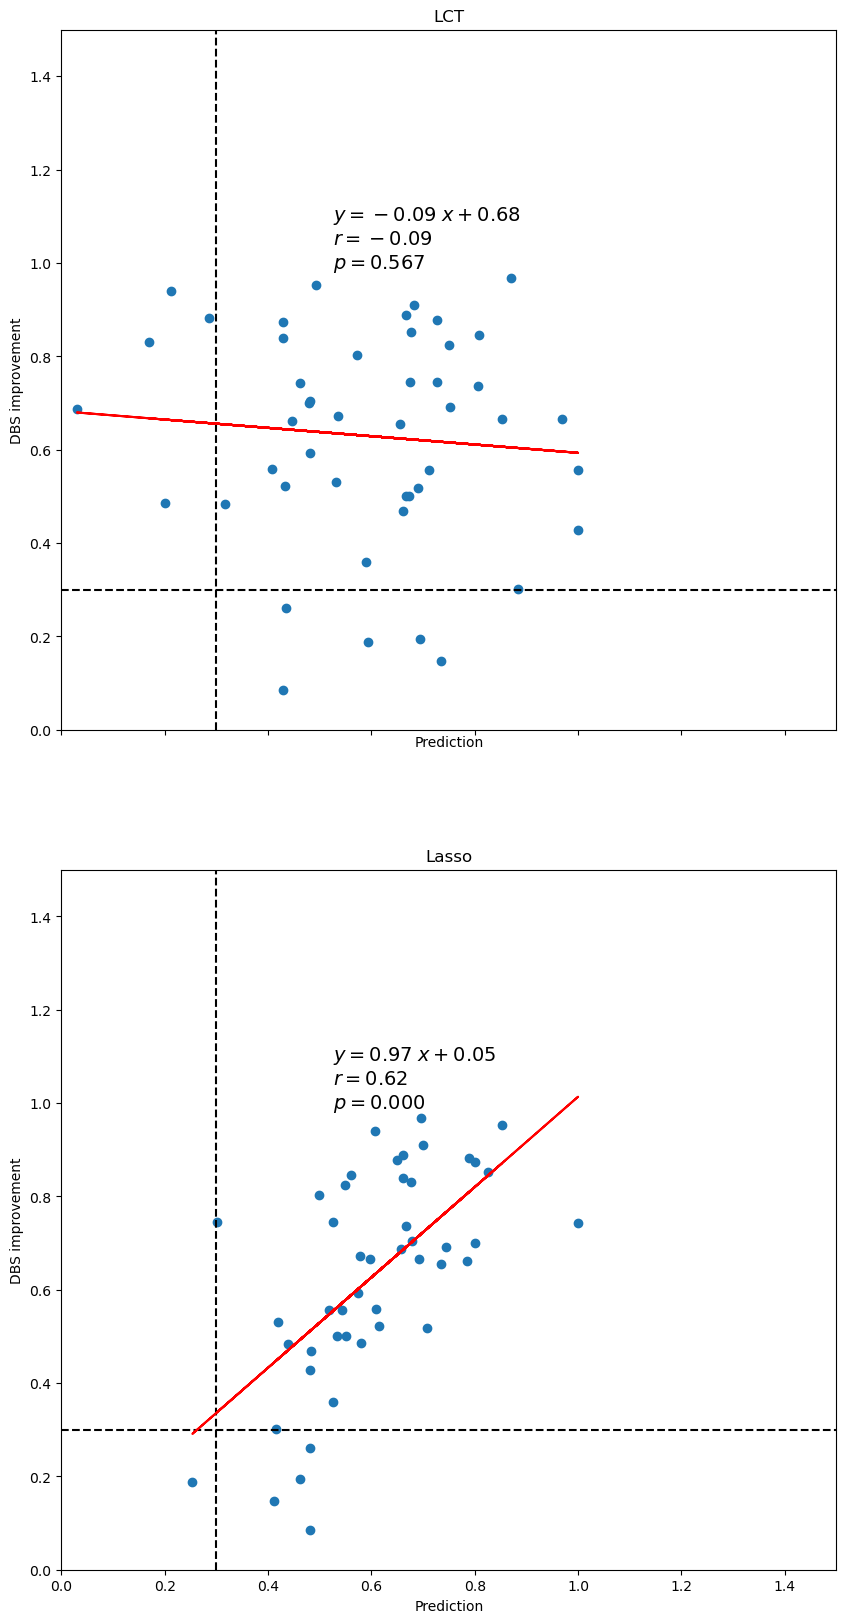

In [17]:
util.eval_prediction(np.vstack((pre_imp,
                               #results_ls,
                               #results_gls,
                               results_bls,
                               )),
                               per_change,
                               ['LCT',
                                #'Latent Lasso',
                                #'VAE regression',
                                'Lasso'
                                ],(20,10))
plt.ylim([0,1.5])
plt.xlim([0,1.5])
plt.style.use('default')

In [14]:
# fig,ax = plt.subplots(3,2,sharex=True,sharey=True)
# plt.style.use('dark_background')
# plt.rcParams["figure.figsize"] = (10,10)
# ax[0,0].scatter(V[:,0]/1000,gerror)
# ax[0,0].set_title('Right red nucleus')
# ax[0,1].scatter(V[:,1]/1000,gerror)
# ax[0,1].set_title('Left red nucleus')
# ax[1,0].scatter(V[:,2]/1000,gerror)
# ax[1,0].set_title('Right substantia nigra')
# ax[1,1].scatter(V[:,3]/1000,gerror)
# ax[1,1].set_title('Left substantia nigra')
# ax[2,0].scatter(V[:,4]/1000,gerror)
# ax[2,0].set_title('Right subthalamic nuclei')
# ax[2,1].scatter(V[:,5]/1000,gerror)
# ax[2,1].set_title('Left subthalamic nuclei')
# plt.setp(ax[-1, :], xlabel='Variance');
# plt.setp(ax[:, 0], ylabel='Error');